# LSTM Long Memory Analysis

Testing whether LSTMs can capture long memory structures using complementary statistical tests based on Greaves-Tunnell & Harchaoui's methodology.

**Test 1**: LSTM trained on fractionally differenced white noise (FD WN)  
**Test 2**: LSTM trained on pure white noise (WN)

Both tests examine the GSE long memory parameter *d* in the LSTM hidden states.

In [ ]:
#Google collab setting
import os
import sys
sys.path.append("LSTM-long-memory")
os.chdir("LSTM-long-memory")

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from _varfima import sim_VARFIMA, sim_FD
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42) #For reproductibility
from d_test import compute_total_memory
import time

##  Building of a LSTM with two layers for multivariate time series prediction

In [3]:
#Let's build the LSTM model for time series prediction

class LSTMPredictor(nn.Module):
    """LSTM for time series prediction"""

    def __init__(self, input_size, hidden_size=64, num_layers=2,
                 dropout=0.2, forecast_horizon=1):
        """
        Args:
            input_size: Number of features (k variables)
            hidden_size: Size of the hidden state
            num_layers: Number of layers in the LSTM
            dropout: Dropout rate between LSTM layers
            forecast_horizon: Number of time steps to predict
        """
        super(LSTMPredictor, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon

        # Couche LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True  # (batch, seq, feature)
        )

        # Couche fully connected pour la prédiction
        self.fc = nn.Linear(hidden_size, input_size * forecast_horizon)

        self.input_size = input_size

    def forward(self, x):
        """
        Args:
            x: (batch, seq_length, input_size)
        Returns:
            predictions: (batch, forecast_horizon, input_size)
        """
        batch_size = x.size(0)

        # LSTM forward
        # lstm_out: (batch, seq_length, hidden_size)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Prendre la dernière sortie temporelle
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Prédiction
        predictions = self.fc(last_output)  # (batch, input_size*forecast_horizon)

        # Reshape pour séparer forecast_horizon et input_size
        predictions = predictions.view(batch_size, self.forecast_horizon,
                                      self.input_size)

        return predictions

k=200

## Test 1: Integration of Fractionnaly Differenced WN

##### Generation of a random Fractionally Differenced White Noise

In [ ]:
# First let's generate a random long memory paramater vector (d)
np.random.seed(42)
k= 200 #number of time series
d_min, d_max = 0.05, 0.45  # to have a long memory vector parameter (d in ]0,0.5[**p)
d = torch.tensor(np.random.uniform(d_min, d_max, size=k), dtype=torch.float32)

#Then let's generated a fractionnally differenced white noise based on the generated d vector, of length T
T=2**16 #same length as in the paper, and same number k of time series
FD_seq, _ = sim_FD(T=2**16, k=200, d=d)

##### Data preparation

In [ ]:
FD_seq.shape #we have a non supervised dataset of shape (k,T)

torch.Size([200, 65536])

In [6]:
# Set device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def unfold_sequence_to_supervised_dataset(data, seq_length, forecast_horizon=1, device='cpu'):
    """
    Create a supervised dataset from multivariate time series sequence.
    with a rolling window approach.
    Args:
        data: torch.Tensor of shape (k, T)
        seq_length: length of the input window (size of X)
        forecast_horizon: number of steps to predict (size of y)

    Returns:
        X: (n_samples, seq_length, k)
        y: (n_samples, forecast_horizon, k)
    """
    data = data.to(device).T  # (T, k) on specified device
    T, k = data.shape

    n_samples = T - seq_length - forecast_horizon + 1

    X = torch.zeros((n_samples, seq_length, k), device=device)
    y = torch.zeros((n_samples, forecast_horizon, k), device=device)

    for idx in range(n_samples):
        X[idx] = data[idx:idx+seq_length]
        y[idx] = data[idx+seq_length:idx+seq_length+forecast_horizon]

    return X.float(), y.float()

Using device: cuda


We transform our generated time serie into a supervised learning dataset thanks to a rolling window of length 10.


In [ ]:
dataset = unfold_sequence_to_supervised_dataset(FD_seq, seq_length=10, forecast_horizon=1, device=device)

print(f"\nTest 1 dataset created on {device}")
print(f"  y memory: {dataset[1].element_size() * dataset[1].nelement() / 1e9:.2f} GB")
print(f"  X memory: {dataset[0].element_size() * dataset[0].nelement() / 1e9:.2f} GB")


Test 1 dataset created on cuda
  y memory: 0.05 GB
  X memory: 0.52 GB


In [ ]:
print(f"Size of X: {dataset[0].shape} \nSize of y: {dataset[1].shape}")

Size of X: torch.Size([65526, 10, 200]) 
Size of y: torch.Size([65526, 1, 200])


In [ ]:
#Let's prepare the dataset of training and validation

#tensorisation of the dataset
full_dataset= torch.utils.data.TensorDataset(dataset[0], dataset[1])

# Split train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Batching
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f" Prepared dataset:")
print(f"  - Train samples: {len(train_dataset)}")
print(f"  - Val samples: {len(val_dataset)}")
print(f"  - Batch size: {batch_size}")


 Prepared dataset:
  - Train samples: 52420
  - Val samples: 13106
  - Batch size: 32


##### Data Training

Entraînement sur cuda
Epoch [5/50] Train Loss: 1.164765 | Val Loss: 1.155995
Epoch [10/50] Train Loss: 1.155856 | Val Loss: 1.148502
Epoch [15/50] Train Loss: 1.152408 | Val Loss: 1.146668
Epoch [20/50] Train Loss: 1.151002 | Val Loss: 1.146045
Epoch [25/50] Train Loss: 1.150035 | Val Loss: 1.146536
Epoch [30/50] Train Loss: 1.131188 | Val Loss: 1.132908
Epoch [35/50] Train Loss: 1.126804 | Val Loss: 1.130281
Epoch [40/50] Train Loss: 1.124442 | Val Loss: 1.129447
Epoch [45/50] Train Loss: 1.122528 | Val Loss: 1.127835
Epoch [50/50] Train Loss: 1.121221 | Val Loss: 1.127615
✓ Entraînement terminé


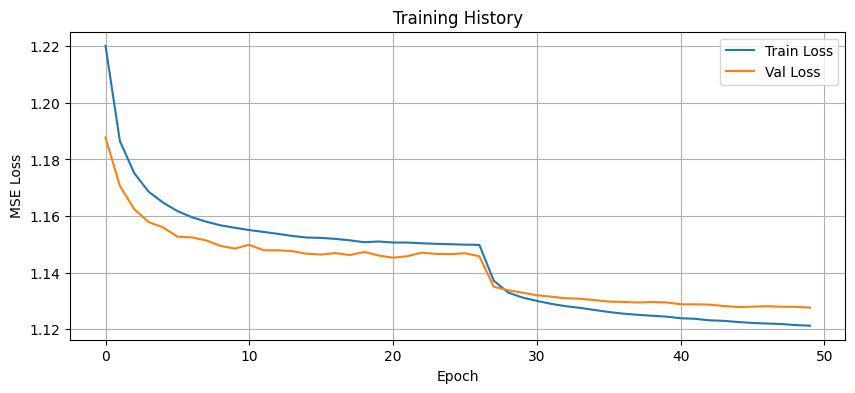

✓ Modèle sauvegardé: lstm_on_fractionnaly_differenciated_WN.pth


In [ ]:
#Let's train the LSTM on the generated data using a ADAM optimizer and MSE loss
#parameters of training:
#for the optimizer: lr=0.01, scheduler (LROnPlateau): patience=5, eps=1e-6
#for the LSTM: 64 hidden size, 2 layers, dropout of 0.2

#Let's load the built LSTM model of two layers adapted to our multivariate time series of size k=200
lstm_model = LSTMPredictor(
    input_size=k,
    hidden_size=64,
    dropout=0.2)

# Configuration (device already set in data preparation)
model = lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, eps=1e-6) #automatic learning rate adjustment

num_epochs = 50 #iteration number

# Historique des pertes
train_losses = []
val_losses = []

print(f"Entraînement sur {device}")
print("=" * 50)

for epoch in range(num_epochs):
    # === TRAINING ===
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Affichage
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("=" * 50)
print("✓ Entraînement terminé")

# Visualisation of loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()

# Let's save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
}, 'lstm_on_fractionnaly_differenciated_WN.pth')

print("✓ Modèle sauvegardé: lstm_on_fractionnaly_differenciated_WN.pth")

#### Let's verify the long memory property in the LSTM trained

First, let's extract the last layer of our trained LSTM

In [ ]:
#Loading the trained model
model.load_state_dict(torch.load('lstm_on_fractionnaly_differenciated_WN.pth')["model_state_dict"])
model.to(device)
model.eval()

#Extract the hidden layer - SEQUENCE COMPLÈTE
hidden_sequences_val = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        lstm_out, (h_n, c_n) = model.lstm(X_batch)
        # lstm_out: (batch_size, seq_length=256, hidden_size=64)
        hidden_sequences_val.append(lstm_out.cpu())

# Concatenate all batches
hidden_rep = torch.cat(hidden_sequences_val, dim=0).numpy()
# Shape: (n_samples, seq_length, hidden_size)

# Reshape to (n_samples * seq_length, hidden_size) to get a true time series
n_samples, seq_length, hidden_size = hidden_rep.shape
hidden_rep_flattened = hidden_rep.reshape(n_samples * seq_length, hidden_size)

print(f"Hidden representation shape: {hidden_rep_flattened.shape}")
print(f"Total timesteps: {hidden_rep_flattened.shape[0]}")
print(f"Hidden state dimension: {hidden_rep_flattened.shape[1]}")



Hidden representation shape: (131060, 64)
Total timesteps: 131060
Hidden state dimension: 64



#### Hypothesis Test
We test:
- **H0**: $d = 0$ ( LSTM does not have long memory)
- **H1**: $d \neq 0$ (LSTM has long memory)

The test uses the GSE statistics to estimate the long memory parameter $d$ from the hidden representation and returns a p-value. And the hypothesis are tested on the last layer of the LSTM

In [ ]:
# Now test on FULL time series, not just last hidden states
hidden_rep_transposed = hidden_rep_flattened.T  # (hidden_size, n_timesteps)

tot_mem_hidden, std_var_hidden, p_val_hidden = compute_total_memory(
    hidden_rep_transposed)

print(f"TEST 1: LSTM trained on Fractionally Differenced White Noise")
print(f"  Total long memory: {tot_mem_hidden:.6f}")
print(f"  Std deviation: {np.sqrt(std_var_hidden):.6f}")
print(f"  p-value (H0: d=0): {p_val_hidden:.4e}")
print(f"\nConclusion:")
if p_val_hidden < 0.05:
    print(f"  ✓ H0 is rejected (p < 0.05): d ≠ 0")
    print(f"  → Hidden states PRESERVE long memory structure")
    print(f"  → LSTM failed the long memory property")
else:
    print(f"  ✗ H0 is accepted (p ≥ 0.05): d ≈ 0")
    print(f"  → Hidden states are white noise (no structure)")
    print(f"  → LSTM captured long memory")

TEST 1: LSTM trained on Fractionally Differenced White Noise
  Total long memory: -0.005466
  Std deviation: 0.062500
  p-value (H0: d=0): 5.3485e-01

Conclusion:
  ✗ H0 is accepted (p ≥ 0.05): d ≈ 0
  → Hidden states are white noise (no structure)
  → LSTM FAILED to capture long memory


We ran the test on the last layer of our LSTM and the test gave a long memory statistic d = 0.0047 and a non significative p-value around 0.7

We can't reject the hypothesis of absence of long memory. The trained LSTM failed to adapt the behaviour of a VARFIMA. It means that it does not have long memory property.

## Test 2: Long memory transformation of white noise

### Generation of a White Noise

In [ ]:
# Generate pure White Noise
np.random.seed(42)
k_wn = 200
T_wn = 2**16
WN_seq = torch.randn(k_wn, T_wn)  # Pure white noise: N(0,1)

print(f"\nGenerated White Noise:")
print(f"  Shape: {WN_seq.shape}")
print(f"  Mean: {WN_seq.mean():.6f} (should be ~0)")
print(f"  Std: {WN_seq.std():.6f} (should be ~1)")
print(f"  Min/Max: [{WN_seq.min():.4f}, {WN_seq.max():.4f}]")


Generated White Noise:
  Shape: torch.Size([200, 65536])
  Mean: -0.000036 (should be ~0)
  Std: 1.000041 (should be ~1)
  Min/Max: [-5.4476, 5.6275]


In [ ]:
# Create supervised dataset with rolling window process on GPU
X_wn, y_wn = unfold_sequence_to_supervised_dataset(
    WN_seq, seq_length=10, forecast_horizon=1, device=device)
print(f"\nTest 2 dataset created on {device}")
print(f"  X memory: {X_wn.element_size() * X_wn.nelement() / 1e9:.2f} GB")
print(f"  y memory: {y_wn.element_size() * y_wn.nelement() / 1e9:.2f} GB")


#Train/test split dataset
full_dataset_wn = TensorDataset(X_wn, y_wn)
train_size_wn = int(0.8 * len(full_dataset_wn))
val_size_wn = len(full_dataset_wn) - train_size_wn

train_dataset_wn, val_dataset_wn = torch.utils.data.random_split(
    full_dataset_wn, [train_size_wn, val_size_wn]
)

train_loader_wn = DataLoader(train_dataset_wn, batch_size=32, shuffle=True)
val_loader_wn = DataLoader(val_dataset_wn, batch_size=32, shuffle=False)

print(f"\nDataset shapes:")
print(f"  X shape: {X_wn.shape}")
print(f"  y shape: {y_wn.shape}")
print(f"  Train samples: {len(train_dataset_wn)}")
print(f"  Val samples: {len(val_dataset_wn)}")


Test 2 dataset created on cuda
  X memory: 0.52 GB
  y memory: 0.05 GB

Dataset shapes:
  X shape: torch.Size([65526, 10, 200])
  y shape: torch.Size([65526, 1, 200])
  Train samples: 52420
  Val samples: 13106


Entraînement sur cuda
Epoch [5/50] Train Loss: 0.998275 | Val Loss: 1.001871
Epoch [10/50] Train Loss: 0.995089 | Val Loss: 1.003683
Epoch [15/50] Train Loss: 0.994434 | Val Loss: 1.004126
Epoch [20/50] Train Loss: 0.994363 | Val Loss: 1.004195
Epoch [25/50] Train Loss: 0.994385 | Val Loss: 1.004204
Epoch [30/50] Train Loss: 0.994403 | Val Loss: 1.004212
Epoch [35/50] Train Loss: 0.994363 | Val Loss: 1.004219
Epoch [40/50] Train Loss: 0.994344 | Val Loss: 1.004228
Epoch [45/50] Train Loss: 0.994293 | Val Loss: 1.004235
Epoch [50/50] Train Loss: 0.994344 | Val Loss: 1.004241
✓ Entraînement terminé


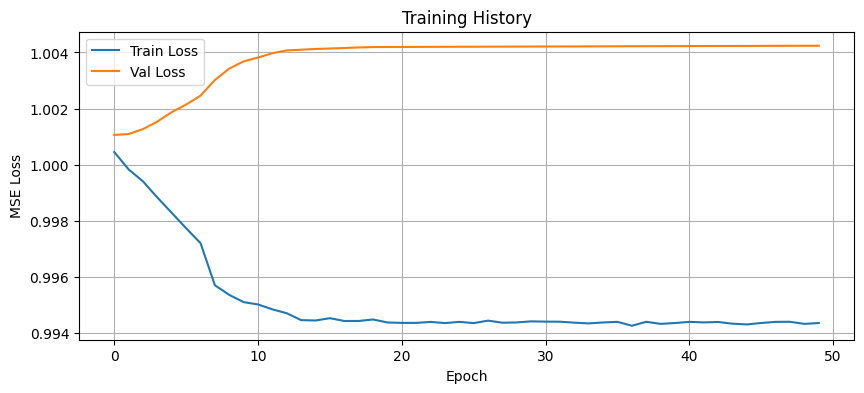

✓ Modèle sauvegardé: lstm_on_WN.pth


In [ ]:
#Let's load the built LSTM model of two layers adapted to our multivariate time series of size k=200
lstm_model = LSTMPredictor(
    input_size=k,
    hidden_size=64,
    dropout=0.3)

# Configuration (device already set in data preparation)
model = lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, eps=1e-6) #automatic learning rate adjustment

num_epochs = 50 #iteration number

# Historique des pertes
train_losses = []
val_losses = []

print(f"Entraînement sur {device}")
print("=" * 50)

for epoch in range(num_epochs):
    # === TRAINING ===
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_wn:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader_wn)
    train_losses.append(train_loss)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader_wn:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader_wn)
    val_losses.append(val_loss)

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Affichage
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("=" * 50)
print("✓ Entraînement terminé")

# Visualisation of loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()

# Let's save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
}, 'lstm_on_WN.pth')

print("✓ Modèle sauvegardé: lstm_on_WN.pth")

The training on the White Noise is less stable than on the Fractionnaly Differenciated White Noise. It is normal since there White noise has  no learnable temporal structure.
To train our LSTM, we chose a bigger dropout between the layers(dropout=0.5) and smaller learning rate for the Adam optimizer (lr=1e-3) in order to minimize this instability in the learning



In [ ]:
#Loading the trained model
model.load_state_dict(torch.load('lstm_on_WN.pth')["model_state_dict"])
model.to(device)
model.eval()

#Extract hidden states on validation set
hidden_states_val = []
with torch.no_grad():
    for X_batch, _ in val_loader_wn:
        X_batch = X_batch.to(device)
        lstm_out, (h_n, c_n) = model.lstm(X_batch)
        hidden_states_val.append(h_n[-1].cpu())

hidden_rep = torch.cat(hidden_states_val, dim=0).numpy()

print(f"Hidden representation shape: {hidden_rep.shape}")
print(f"Number of time steps in test: {hidden_rep.shape[0]}")
print(f"Hidden state dimension: {hidden_rep.shape[1]}")

Hidden representation shape: (13106, 64)
Number of time steps in test: 13106
Hidden state dimension: 64


In [ ]:
# Test long memory on LSTM hidden states

hidden_rep_transposed = hidden_rep.T

tot_mem_hidden, std_var_hidden, p_val_hidden = compute_total_memory(
    hidden_rep_transposed)

print(f"TEST 2: Transformation of WN by LSTM")
print(f"  Total long memory: {tot_mem_hidden:.6f}")
print(f"  Std deviation: {np.sqrt(std_var_hidden):.6f}")
print(f"  p-value (H0: d=0): {p_val_hidden:.4e}")
print(f"\nConclusion:")
if p_val_hidden < 0.05:
    print(f"  ✗ H0 is rejected (p < 0.05): d ≠ 0")
    print(f"  →  LSTM has long memory property")
else:
    print(f"   H0 is accepted (p ≥ 0.05): d ≈ 0")
    print(f" →  LSTM has no long memory property")

TEST 2: Transformation of WN by LSTM
  Total long memory: -0.003607
  Std deviation: 0.062500
  p-value (H0: d=0): 5.2301e-01

Conclusion:
   H0 is accepted (p ≥ 0.05): d ≈ 0
 →  LSTM has no long memory property


### Monte Carlo Simulation

In [ ]:
import time

# ============================================================
# MONTE CARLO SIMULATIONS: n=10 iterations for Test 1 and Test 2
# ============================================================

n_simulations = 10
d_min, d_max = 0.05, 0.45  # Range for fractional differencing parameter

print("="*70)
print("MONTE CARLO SIMULATIONS: n=10 for Test 1 (FD WN) and Test 2 (WN)")
print("="*70)

# Results storage
test1_results = {
    'total_memory': [],
    'std_deviation': [],
    'p_values': [],
    'h0_rejected': []
}

test2_results = {
    'total_memory': [],
    'std_deviation': [],
    'p_values': [],
    'h0_rejected': []
}

# ============================================================
# TEST 1: LSTM TRAINED ON FRACTIONALLY DIFFERENCED WHITE NOISE (n=10)
# ============================================================
print("\n" + "="*70)
print("TEST 1: LSTM on Fractionally Differenced White Noise")
print("="*70)

for sim in range(n_simulations):
    print(f"\n--- Simulation {sim+1}/{n_simulations} ---")

    # Generate new random d vector (k values)
    np.random.seed(42 + sim)  # Different seed for each simulation
    d_vector = torch.tensor(np.random.uniform(d_min, d_max, size=200), dtype=torch.float32)

    # Generate FD WN
    FD_WN_new, _ = sim_FD(T=2**16, k=200, d=d_vector)
    FD_WN_seq_new = FD_WN_new.float()

    # Create dataset
    X_fd_new, y_fd_new = unfold_sequence_to_supervised_dataset(
        FD_WN_seq_new, seq_length=10, forecast_horizon=1, device=device)

    full_dataset_fd = TensorDataset(X_fd_new, y_fd_new)
    train_size_fd = int(0.8 * len(full_dataset_fd))
    val_size_fd = len(full_dataset_fd) - train_size_fd

    train_dataset_fd, val_dataset_fd = torch.utils.data.random_split(
        full_dataset_fd, [train_size_fd, val_size_fd])

    train_loader_fd = DataLoader(train_dataset_fd, batch_size=32, shuffle=True)
    val_loader_fd = DataLoader(val_dataset_fd, batch_size=32, shuffle=False)

    # Initialize and train LSTM
    lstm_model_test1 = LSTMPredictor(input_size=200, hidden_size=64, dropout=0.2)
    model_test1 = lstm_model_test1.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_test1.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, eps=1e-6)

    num_epochs = 50

    # Train
    for epoch in range(num_epochs):
        model_test1.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader_fd:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            predictions = model_test1(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader_fd)

        # Validation
        model_test1.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader_fd:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model_test1(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader_fd)
        scheduler.step(val_loss)

    # Extract hidden states
    hidden_sequences_test1 = []
    with torch.no_grad():
        for X_batch, _ in val_loader_fd:
            X_batch = X_batch.to(device)
            lstm_out, _ = model_test1.lstm(X_batch)
            hidden_sequences_test1.append(lstm_out.cpu())

    hidden_rep_test1 = torch.cat(hidden_sequences_test1, dim=0).numpy()
    n_samples, seq_length, hidden_size = hidden_rep_test1.shape
    hidden_rep_flat_test1 = hidden_rep_test1.reshape(n_samples * seq_length, hidden_size)
    hidden_rep_transposed_test1 = hidden_rep_flat_test1.T

    # Compute long memory statistics
    tot_mem_test1, std_var_test1, p_val_test1 = compute_total_memory(hidden_rep_transposed_test1)

    test1_results['total_memory'].append(tot_mem_test1)
    test1_results['std_deviation'].append(np.sqrt(std_var_test1))
    test1_results['p_values'].append(p_val_test1)
    test1_results['h0_rejected'].append(p_val_test1 < 0.05)

    print(f"  Total long memory d: {tot_mem_test1:.6f}")
    print(f"  Std deviation: {np.sqrt(std_var_test1):.6f}")
    print(f"  p-value: {p_val_test1:.4e}")
    print(f"  H0 rejected: {'Yes' if p_val_test1 < 0.05 else 'No'}")

# Summary for Test 1
print("\n" + "-"*70)
print("TEST 1 SUMMARY (FD WN)")
print("-"*70)
print(f"Mean d: {np.mean(test1_results['total_memory']):.6f} ± {np.std(test1_results['total_memory']):.6f}")
print(f"Mean p-value: {np.mean(test1_results['p_values']):.4e}")
print(f"H0 rejection rate: {np.mean(test1_results['h0_rejected'])*100:.1f}%")
print(f"Interpretation: LSTM {'FAILED' if np.mean(test1_results['h0_rejected']) > 0.5 else 'PASSED'} to capture long memory")

# ============================================================
# TEST 2: LSTM TRAINED ON WHITE NOISE (n=10)
# ============================================================
print("\n" + "="*70)
print("TEST 2: LSTM on White Noise")
print("="*70)

for sim in range(n_simulations):
    print(f"\n--- Simulation {sim+1}/{n_simulations} ---")

    # Generate new random WN
    np.random.seed(42 + sim)  # Same seed offset for consistency
    WN_new = torch.randn(200, 2**16)

    # Create dataset
    X_wn_new, y_wn_new = unfold_sequence_to_supervised_dataset(
        WN_new, seq_length=10, forecast_horizon=1, device=device)

    full_dataset_wn_new = TensorDataset(X_wn_new, y_wn_new)
    train_size_wn = int(0.8 * len(full_dataset_wn_new))
    val_size_wn = len(full_dataset_wn_new) - train_size_wn

    train_dataset_wn_new, val_dataset_wn_new = torch.utils.data.random_split(
        full_dataset_wn_new, [train_size_wn, val_size_wn])

    train_loader_wn_new = DataLoader(train_dataset_wn_new, batch_size=32, shuffle=True)
    val_loader_wn_new = DataLoader(val_dataset_wn_new, batch_size=32, shuffle=False)

    # Initialize and train LSTM
    lstm_model_test2 = LSTMPredictor(input_size=200, hidden_size=64, dropout=0.3)
    model_test2 = lstm_model_test2.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_test2.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, eps=1e-6)

    num_epochs = 50

    # Train
    for epoch in range(num_epochs):
        model_test2.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader_wn_new:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            predictions = model_test2(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader_wn_new)

        # Validation
        model_test2.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader_wn_new:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model_test2(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader_wn_new)
        scheduler.step(val_loss)

    # Extract hidden states
    hidden_sequences_test2 = []
    with torch.no_grad():
        for X_batch, _ in val_loader_wn_new:
            X_batch = X_batch.to(device)
            lstm_out, _ = model_test2.lstm(X_batch)
            hidden_sequences_test2.append(lstm_out.cpu())

    hidden_rep_test2 = torch.cat(hidden_sequences_test2, dim=0).numpy()
    n_samples, seq_length, hidden_size = hidden_rep_test2.shape
    hidden_rep_flat_test2 = hidden_rep_test2.reshape(n_samples * seq_length, hidden_size)
    hidden_rep_transposed_test2 = hidden_rep_flat_test2.T

    # Compute long memory statistics
    tot_mem_test2, std_var_test2, p_val_test2 = compute_total_memory(hidden_rep_transposed_test2)

    test2_results['total_memory'].append(tot_mem_test2)
    test2_results['std_deviation'].append(np.sqrt(std_var_test2))
    test2_results['p_values'].append(p_val_test2)
    test2_results['h0_rejected'].append(p_val_test2 < 0.05)

    print(f"  Total long memory d: {tot_mem_test2:.6f}")
    print(f"  Std deviation: {np.sqrt(std_var_test2):.6f}")
    print(f"  p-value: {p_val_test2:.4e}")
    print(f"  H0 rejected: {'Yes' if p_val_test2 < 0.05 else 'No'}")

# Summary for Test 2
print("\n" + "-"*70)
print("TEST 2 SUMMARY (WN)")
print("-"*70)
print(f"Mean d: {np.mean(test2_results['total_memory']):.6f} ± {np.std(test2_results['total_memory']):.6f}")
print(f"Mean p-value: {np.mean(test2_results['p_values']):.4e}")
print(f"H0 rejection rate: {np.mean(test2_results['h0_rejected'])*100:.1f}%")
print(f"Interpretation: LSTM {'FAILED' if np.mean(test2_results['h0_rejected']) > 0.5 else 'PASSED'} to capture long memory")

# ============================================================
# COMPARATIVE ANALYSIS
# ============================================================
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS")
print("="*70)
print(f"\nTest 1 (FD WN) vs Test 2 (WN):")
print(f"  Mean d difference: {abs(np.mean(test1_results['total_memory']) - np.mean(test2_results['total_memory'])):.6f}")
print(f"  Test 1 rejection rate: {np.mean(test1_results['h0_rejected'])*100:.1f}%")
print(f"  Test 2 rejection rate: {np.mean(test2_results['h0_rejected'])*100:.1f}%")
print(f"\nConclusion:")
if np.mean(test1_results['h0_rejected']) < 0.5 and np.mean(test2_results['h0_rejected']) > 0.5:
    print("  ✓ LSTM successfully captures long memory from FD WN")
    print("  ✓ LSTM learns the VARFIMA structure for fractionally differenced data")
elif np.mean(test1_results['h0_rejected']) > 0.5 and np.mean(test2_results['h0_rejected']) < 0.5:
    print("  ✗ LSTM fails to capture long memory from FD WN")
    print("  ✗ LSTM does not learn the VARFIMA structure")
else:
    print("  ? Mixed results - LSTM behavior is inconclusive")

MONTE CARLO SIMULATIONS: n=10 for Test 1 (FD WN) and Test 2 (WN)

TEST 1: LSTM on Fractionally Differenced White Noise

--- Simulation 1/10 ---
  Total long memory d: -0.006122
  Std deviation: 0.062500
  p-value: 5.3902e-01
  H0 rejected: No

--- Simulation 2/10 ---
  Total long memory d: -0.002170
  Std deviation: 0.062500
  p-value: 5.1385e-01
  H0 rejected: No

--- Simulation 3/10 ---
  Total long memory d: 0.004569
  Std deviation: 0.062500
  p-value: 4.7086e-01
  H0 rejected: No

--- Simulation 4/10 ---
  Total long memory d: -0.005382
  Std deviation: 0.062500
  p-value: 5.3431e-01
  H0 rejected: No

--- Simulation 5/10 ---
  Total long memory d: -0.005855
  Std deviation: 0.062500
  p-value: 5.3732e-01
  H0 rejected: No

--- Simulation 6/10 ---
  Total long memory d: 0.003152
  Std deviation: 0.062500
  p-value: 4.7989e-01
  H0 rejected: No

--- Simulation 7/10 ---
  Total long memory d: -0.004820
  Std deviation: 0.062500
  p-value: 5.3074e-01
  H0 rejected: No

--- Simulation